# K-Mean Clustering

Based on the given dataset containing information about transactions, We can find an insight by using customer purchasing behavior using data mining technique called `K-Mean`. I would help buisness identify Customer Segmentation that share similar characteristics.

Data
* number of customers' transtions for each daytime interval (Morning, AfterNoon, Evening)
* number of each customers visiting particular stores
* number of each customers' purchasing

## Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import *
from pyspark.sql.types import *
from pyspark import SparkConf

In [2]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.linalg import Vectors, VectorUDT

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [3]:
from itertools import chain

# Udf func, convert Vector to Array(Double)
ToArray  = udf(lambda row : row.toArray().tolist() ,  ArrayType( DoubleType() , containsNull=False ) )
# Convert list to Vector
ToVector = udf(lambda row : Vectors.dense( row ), VectorUDT() )

In [4]:
import matplotlib.pyplot as plt

In [5]:
# Function to assebly all feature into single array and nomalize it
def assemblyAndNormalizeFeatures(dataFrame, inputCols):
    assembler = VectorAssembler(
        inputCols=inputCols,
        outputCol="features")
    
    data_ = assembler.transform(dataFrame)
    
    normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=2.0)
    norm_data  = normalizer.transform(data_)
    norm_data  = norm_data.withColumn("normFeatures", ToArray( norm_data.normFeatures ) )
    
    return norm_data

## Set Up SparkContext and SparkSession

In [6]:
spark = SparkSession \
        .builder \
        .appName("SuperMarket Analytic Clustering") \
        .enableHiveSupport() \
        .getOrCreate()

sc = spark.sparkContext

## Data Pre-processing 

In [7]:
df = spark.sql("""
SELECT *
FROM default.supermarket
""").cache()

df = df.withColumn("SHOP_TIME", 
                    when( col("SHOP_HOUR") >= 17  , "Evening")
                   .when( col("SHOP_HOUR") >= 12  , "Afternoon")
                   .when( col("SHOP_HOUR") >= 5   , "Morning")
                   .otherwise("Unknown") )

df.show(5)

+---------+---------+---------------+--------------+----------+----------+--------+-----+---------+
|SHOP_DATE|SHOP_HOUR|      BASKET_ID|     CUST_CODE|STORE_CODE| PROD_CODE|QUANTITY|SPEND|SHOP_TIME|
+---------+---------+---------------+--------------+----------+----------+--------+-----+---------+
| 20071006|       21|994107800268406|CUST0000153531|STORE00001|PRD0901391|       1| 0.37|  Evening|
| 20070201|       15|994104300305853|CUST0000219191|STORE00002|PRD0901915|       1| 5.08|Afternoon|
| 20071103|       13|994108200514137|CUST0000526979|STORE00003|PRD0903379|       1| 2.36|Afternoon|
| 20070206|       18|994104400743650|CUST0000913709|STORE00004|PRD0903305|       1|  0.2|  Evening|
| 20071015|       19|994108000780959|CUST0000961285|STORE00001|PRD0903387|       1| 1.65|  Evening|
+---------+---------+---------------+--------------+----------+----------+--------+-----+---------+
only showing top 5 rows



## Customer shopping time data

In [8]:
Shop_Time_Cnt = df.select("CUST_CODE", "SHOP_TIME", "BASKET_ID") \
                .groupBy("CUST_CODE", "SHOP_TIME", "BASKET_ID") \
                .count() \
                .select("CUST_CODE", "SHOP_TIME", "count") \
                .groupBy("CUST_CODE") \
                .pivot("SHOP_TIME") \
                .sum("count") \
                .na.fill(0) \
                .cache()

Shop_Time_Cnt.select('CUST_CODE', 'Morning', 'Afternoon', 'Evening').show(5)

+--------------+-------+---------+-------+
|     CUST_CODE|Morning|Afternoon|Evening|
+--------------+-------+---------+-------+
|CUST0000406764|      0|        4|      0|
|CUST0000406938|      0|        4|      2|
|CUST0000015753|      0|        3|      1|
|CUST0000780018|      0|        3|      0|
|CUST0000070552|      3|        8|      3|
+--------------+-------+---------+-------+
only showing top 5 rows



In [9]:
Shop_Time_Feature = assemblyAndNormalizeFeatures(Shop_Time_Cnt, ['Morning', 'Afternoon', 'Evening']) \
                    .select('CUST_CODE', 'normFeatures') \
                    .withColumnRenamed('normFeatures', 'Shop_Time_Features')

In [10]:
Shop_Time_Feature.show(5)

+--------------+--------------------+
|     CUST_CODE|  Shop_Time_Features|
+--------------+--------------------+
|CUST0000406764|     [0.0, 1.0, 0.0]|
|CUST0000406938|[0.0, 0.894427190...|
|CUST0000015753|[0.0, 0.948683298...|
|CUST0000780018|     [0.0, 1.0, 0.0]|
|CUST0000070552|[0.33129457822453...|
+--------------+--------------------+
only showing top 5 rows



In [11]:
Store_Count = df.select("CUST_CODE", "STORE_CODE", "BASKET_ID") \
                .groupBy("CUST_CODE", "STORE_CODE", "BASKET_ID") \
                .count() \
                .select("CUST_CODE", "STORE_CODE", "count") \
                .groupBy("CUST_CODE") \
                .pivot("STORE_CODE") \
                .sum("count") \
                .na.fill(0) \
                .cache()

Store_Count.select('CUST_CODE', 'STORE00001', 'STORE00002', 'STORE00003', 'STORE00004').show(5)

+--------------+----------+----------+----------+----------+
|     CUST_CODE|STORE00001|STORE00002|STORE00003|STORE00004|
+--------------+----------+----------+----------+----------+
|CUST0000352224|         0|         0|        40|         0|
|CUST0000704359|         0|         0|         9|         0|
|CUST0000406764|         0|         0|         4|         0|
|CUST0000982585|         0|        15|         0|         0|
|CUST0000793437|         0|         0|         3|         0|
+--------------+----------+----------+----------+----------+
only showing top 5 rows



In [12]:
Store_Feature = assemblyAndNormalizeFeatures(Store_Count, ['STORE00001', 'STORE00002', 'STORE00003', 'STORE00004']) \
                .select('CUST_CODE', 'normFeatures') \
                .withColumnRenamed('normFeatures', 'Store_Features')

In [13]:
Store_Feature.show(5)

+--------------+--------------------+
|     CUST_CODE|      Store_Features|
+--------------+--------------------+
|CUST0000352224|[0.0, 0.0, 1.0, 0.0]|
|CUST0000704359|[0.0, 0.0, 1.0, 0.0]|
|CUST0000406764|[0.0, 0.0, 1.0, 0.0]|
|CUST0000982585|[0.0, 1.0, 0.0, 0.0]|
|CUST0000793437|[0.0, 0.0, 1.0, 0.0]|
+--------------+--------------------+
only showing top 5 rows



In [14]:
Cust_Prod_Sum = spark.sql("""
SELECT *
FROM default.pivot_cust_prod_sum
""")

In [15]:
ignore = ['CUST_CODE']
featuresList = [x for x in Cust_Prod_Sum.columns if x not in ignore]

Prod_Feature = assemblyAndNormalizeFeatures(Cust_Prod_Sum, featuresList) \
                .select('CUST_CODE', 'normFeatures') \
                .withColumnRenamed('normFeatures', 'Prod_Features')

In [16]:
Prod_Feature.show(5)

+--------------+--------------------+
|     CUST_CODE|       Prod_Features|
+--------------+--------------------+
|CUST0000336458|[0.0, 0.0, 0.0, 0...|
|CUST0000063499|[0.0, 0.0, 0.0, 0...|
|CUST0000032037|[0.0, 0.0, 0.0, 0...|
|CUST0000895912|[0.0, 0.0, 0.0, 0...|
|CUST0000344205|[0.0, 0.0, 0.0, 0...|
+--------------+--------------------+
only showing top 5 rows



In [17]:
data1 = Shop_Time_Feature.alias('d1')
data2 = Store_Feature.alias('d2')
data3 = Prod_Feature.alias('d3')

data = data1.join(data2, data2.CUST_CODE == data1.CUST_CODE) \
            .select( col("d1.CUST_CODE"), col("d1.Shop_Time_Features"), col("d2.Store_Features") ) \
            .join(data3, data3.CUST_CODE == data1.CUST_CODE) \
            .select( col("d1.CUST_CODE"), col("d1.Shop_Time_Features"), col("d2.Store_Features"), col("d3.Prod_Features") ) \
            .cache()

In [18]:
data.show(5)

+--------------+--------------------+--------------------+--------------------+
|     CUST_CODE|  Shop_Time_Features|      Store_Features|       Prod_Features|
+--------------+--------------------+--------------------+--------------------+
|CUST0000352224|[0.0, 0.670913323...|[0.0, 0.0, 1.0, 0.0]|[0.0, 0.0, 0.0, 0...|
|CUST0000704359|[0.0, 0.961523947...|[0.0, 0.0, 1.0, 0.0]|[0.0, 0.0, 0.0, 0...|
|CUST0000406764|     [0.0, 1.0, 0.0]|[0.0, 0.0, 1.0, 0.0]|[0.0, 0.0, 0.0, 0...|
|CUST0000982585|[0.0, 0.894427190...|[0.0, 1.0, 0.0, 0.0]|[0.0, 0.0, 0.0, 0...|
|CUST0000793437|     [0.0, 1.0, 0.0]|[0.0, 0.0, 1.0, 0.0]|[0.0, 0.0, 0.0, 0...|
+--------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [19]:
assembler = VectorAssembler(
    inputCols=['Shop_Time_Features', 'Store_Features', 'Prod_Features'],
    outputCol="features")

all_features = data.withColumn("Shop_Time_Features", ToVector("Shop_Time_Features")) \
                   .withColumn("Store_Features"    , ToVector("Store_Features")) \
                   .withColumn("Prod_Features"     , ToVector("Prod_Features"))

all_features = assembler.transform(all_features) \
                        .withColumn("features", ToArray("features")) \
                        .select("CUST_CODE", "features") \
                        .cache()

In [26]:
import numpy as np

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(all_features.sample(False,0.33, seed=9999))
    cost[k] = model.computeCost(all_features) 
    print(cost[k])

9267.32738508847
7850.55786194073
7558.443361614961
6680.066545970851
6317.17710130342
6141.141511215641
5887.746931962584
5836.571909081572
5600.241509578733
5575.4116730067435
5381.824322898742
5326.500413357726
5122.524279802747
5128.393503767463
5068.964883103307
5099.989753565226
5140.682575805671
5074.540747389407


Text(0, 0.5, 'cost')

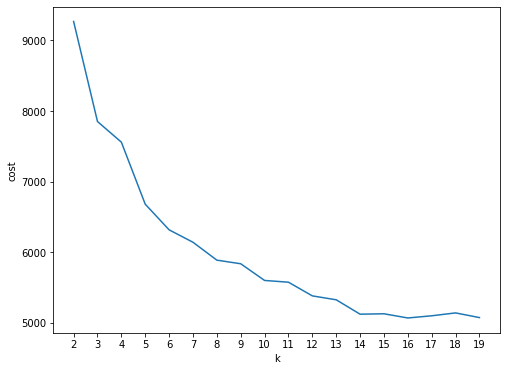

In [27]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.xaxis.set_ticks(np.arange(2, 20, 1))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [28]:
# Best K = 11, K-Mean Clustering

k = 11
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit( all_features )
centers = model.clusterCenters()

In [29]:
transformed = model.transform(all_features).select('CUST_CODE', 'prediction')
rows = transformed.collect()
result = spark.createDataFrame(rows)

In [30]:
result.show(10)

+--------------+----------+
|     CUST_CODE|prediction|
+--------------+----------+
|CUST0000352224|         7|
|CUST0000704359|         6|
|CUST0000406764|         6|
|CUST0000982585|         3|
|CUST0000793437|         6|
|CUST0000175152|         2|
|CUST0000780018|         3|
|CUST0000076764|         0|
|CUST0000940284|         7|
|CUST0000070552|         3|
+--------------+----------+
only showing top 10 rows



In [31]:
result.select("CUST_CODE", "prediction").groupBy("prediction").count().orderBy("prediction").show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  393|
|         1|    1|
|         2|  840|
|         3|  784|
|         4|  232|
|         5|  762|
|         6|  603|
|         7|  519|
|         8|  123|
|         9|  409|
|        10|  225|
+----------+-----+

